<a href="https://colab.research.google.com/github/Laxmi-Prajapati/Synapse_LP/blob/Week_3/Synapse_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 3**

## **DJS Synapse Learning Period**
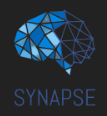

**Unsupervised Learning**

Clustering is an unsupervised learning technique used to group similar data points together. It's widely used in various applications like customer segmentation, anomaly detection, and more. In this task, we'll explore different clustering algorithms and visualize their results.

We will work with the **Samsung Human Activity Recognition dataset**. The data comes from the accelerometers and gyros of Samsung mobile phones, the type of activity of a person with a phone in his pocket is also known - whether he walked, stood, lay, sat or walked up or down the stairs.

We imagine that the type of activity is unknown to us (unlabelled), and we will try to cluster people purely on the basis of available features.

The dataset that will be used can be found here - [DATA](https://drive.google.com/drive/folders/1K2IP3MOVwDQp3UWTCEUae-4roZrE1Rfv?usp=drive_link)

# Importing and Installing all the necessary libaries

In [1]:
!pip install exkmc yellowbrick -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from ExKMC.Tree import Tree

from IPython.display import Image,display
from ipywidgets import interact
import os

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Mount your google drive

In [2]:
# code here
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Loading

Mention the path of dataset, 4 paths for the 4 different txt files.

In [3]:
# Mention the path in the strings below
samsung_train_path = '/content/gdrive/My Drive/synapse_w4/samsung_train.txt'
samsung_train_labels_path = '/content/gdrive/My Drive/synapse_w4/samsung_train_labels.txt'
samsung_test_path = '/content/gdrive/My Drive/synapse_w4/samsung_test.txt'
samsung_test_labels_path = '/content/gdrive/My Drive/synapse_w4/samsung_test_labels.txt'

This time we will be using np.loadtxt() for reading our data. Code for the same has been given (do not modify), but we expect you to understand the working of it.

Ref.: https://www.geeksforgeeks.org/numpy-loadtxt-in-python/

In [4]:
# DO NOT MODIFY
X_train = np.loadtxt(samsung_train_path)
y_train = np.loadtxt(samsung_train_labels_path).astype(int)

X_test = np.loadtxt(samsung_test_path)
y_test = np.loadtxt(samsung_test_labels_path).astype(int)

Just to confirm that your data has been loaded properly, execute the below cell. You won't receive any error if everything is correct.

NOTE: If you get an Assertion error, then you probably did something wrong above.

In [5]:
# Checking dimensions
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

# **Pre-processing**

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge *X_train* with *X_test*, and *y_train* with *y_test*.

Hint:
1. Merge X_train and X_test into X {use [np.vstack()](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html)}
2. Merge y_train and y_test into y {use [np.hstack()](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html)}

In [6]:
# Uncomment the below lines and code
X = np.vstack((X_train,X_test))
y = np.hstack((y_train,y_test))

Using numpy, print the unique values of the labels of the target class (i.e. "y").

Ref.: https://www.geeksforgeeks.org/python-numpy-np-unique-method/


In [7]:
# code here
uni = np.unique(y)
uni

array([1, 2, 3, 4, 5, 6])

Store the size (or number) of unique values of the labels of the target class (i.e. "y") in a variable named n_classes.

In [8]:
# Uncomment the below line and code
n_classes = len(uni)
n_classes

6

In [9]:
activities = [
    "walking",
    "going up the stairs",
    "going down the stairs",
    "sitting",
    "standing",
    "lying down"
]

Here the 6 labels (or classes) correspond to:
- 1 - walking
- 2 - going up the stairs
- 3 - going down the stairs
- 4 - sitting
- 5 - standing
- 6 - lying down

So we wish to create 6 clusters where each cluster can represent one of the above activities.

Scale the sample (i.e. X) using [`StandardScaler()`](https://www.digitalocean.com/community/tutorials/standardscaler-function-in-python)

In [10]:
from sklearn.preprocessing import StandardScaler
# initialize an instance of StandardScaler()
scaler = StandardScaler()
# use the above instance to fit_transform "X" and assign it into a new variable "X_scaled"
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.10533854e-01, -6.87026385e-02, -4.52194533e-01, ...,
        -6.74432366e-01,  3.82007658e-01, -1.61505480e-02],
       [ 6.02084832e-02,  3.59023537e-02, -2.75221885e-01, ...,
        -6.81359801e-01,  3.83147865e-01, -1.20627169e-04],
       [ 7.84597052e-02, -4.64269585e-02, -8.55480582e-02, ...,
        -6.89470939e-01,  3.84288531e-01,  1.92144041e-02],
       ...,
       [ 1.11821625e+00,  1.28805864e+00, -1.29414692e-01, ...,
        -3.10750224e-01,  6.91509049e-01,  8.75719123e-01],
       [-5.43492722e-01,  9.75327452e-01,  2.34319837e-01, ...,
        -3.19283719e-01,  6.59762215e-01,  8.99444350e-01],
       [-1.78515253e+00, -1.86663622e-02, -5.29759691e-01, ...,
        -3.19991245e-01,  6.56994458e-01,  9.01454465e-01]])

# **Dimensionality Reduction using PCA**

Ref.: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [11]:
# Import PCA from sklearn.decomposition
from sklearn.decomposition import PCA

Reduce the number of dimensions using PCA,

Hints:
1. Initialise instance of PCA and set *n_components* to 0.9 and *random_state* to 17.
2. Fit X_scaled over the PCA instance created
3. Transform X_scaled over the fitted PCA instance and store it in a variable named X_pca.

Theory: https://www.analyticsvidhya.com/blog/2022/07/principal-component-analysis-beginner-friendly/ and https://en.wikipedia.org/wiki/Principal_component_analysis

Theory + Implementation.: https://youtu.be/OFyyWcw2cyM (Jump to timestamp - 13:50 for PCA implementaion)

In [12]:
# code here
pc = PCA(n_components=0.9,random_state=17)
pc.fit(X_scaled)
X_pca = pc.transform(X_scaled)

Let's check the shape of X_pca.

In [13]:
# code here
X_pca.shape
# Should print (10299, 65) if everything is correct.

(10299, 65)

Shape of X was (10299, 561) i.e 561 dimensions

Shape of X_pca is (10299, 65) i.e. 65 dimenisons

Hence we have successfully reduced dimensions using PCA.

# K-Means Clustering (Partition-Based Clustering)

K-means clustering is an essential partitioning algorithm used to categorize a dataset into 'k' distinct, non-overlapping clusters. Each data point is assigned to the cluster with the nearest mean or centroid, symbolizing the cluster's center. The primary goal of the algorithm is to minimize the sum of squared distances between data points and their respective cluster centroids.

For an in-depth exploration of K-means clustering, you can refer to this comprehensive article on Analytics Vidhya: [Comprehensive Guide to K-means Clustering](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/).

For a deeper understanding of the mathematical underpinnings of K-means clustering, Wikipedia is a valuable resource. You can explore the Wikipedia page on K-means clustering for a detailed description: [K-means Clustering Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering). This will help you grasp the mathematical intricacies of the algorithm and its applications in machine learning.

### 2 Dimensional Visualization

In [14]:
## Perform K-Means clustering with interactive widget
def kmeans_clustering(num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_pca)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolors='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
    plt.xlabel('Feature 1 (Standardized)')
    plt.ylabel('Feature 2 (Standardized)')
    plt.title('K-Means Clustering')
    plt.legend()
    plt.show()

low = 2
high = 6
scale = 1

interact(kmeans_clustering, num_clusters=(low,high,scale))

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.kmeans_clustering(num_clusters)>

### 3 Dimensional Visualization

In [15]:
## Perform K-Means clustering with interactive widget
def kmeans_3d_clustering(num_clusters):
    kmeans_3d = KMeans(n_clusters=num_clusters, random_state=42)# Write Code Here
    kmeans_3d_labels = kmeans_3d.fit_predict(X_pca)# Write Code Here

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=kmeans_3d_labels, cmap='viridis', edgecolors='k')
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')
    ax.set_zlabel('Feature 3 (Standardized)')
    ax.set_title('Kmeans Clustering (3D)')
    plt.show()

interact(kmeans_3d_clustering, num_clusters=(2, 6, 1))

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.kmeans_3d_clustering(num_clusters)>

### Elbow Point

The "elbow point" is a concept often used in the context of K-means clustering to help determine the optimal number of clusters (k) for a given dataset. It is a graphical method that can assist data analysts and machine learning practitioners in finding an appropriate value for k when applying K-means clustering.

The rationale behind the elbow point method is that as you increase the number of clusters (k), the sum of squared distances will generally decrease because data points will be closer to their respective cluster centroids. However, beyond a certain point, subdividing the data into more clusters doesn't provide significant improvements in reducing the sum of squared distances. The elbow point represents that optimal trade-off between the number of clusters and the compactness of each cluster.

It's important to note that the elbow point method is a heuristic and not a foolproof method for determining the ideal k value. In some cases, the elbow point may not be very pronounced, making it challenging to choose the best k. Additionally, the choice of k should also consider domain knowledge and the specific goals of your analysis.


Elbow Method to determine the number of clusters to be formed:


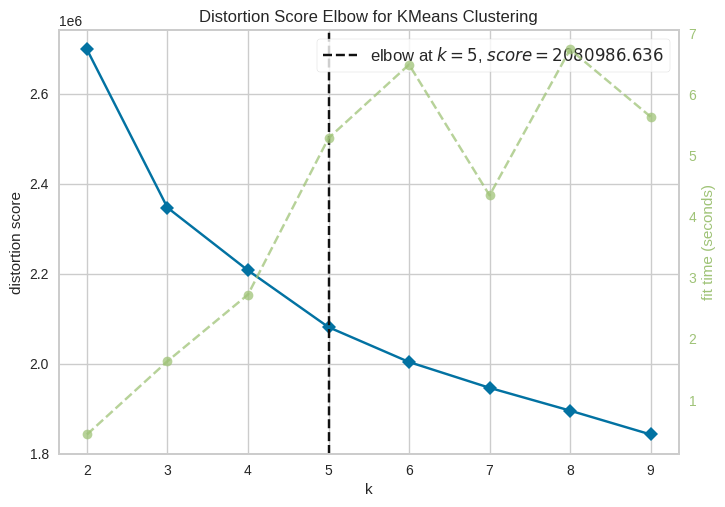

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
print('Elbow Method to determine the number of clusters to be formed:')

Elbow_M = KElbowVisualizer(KMeans(), k=(2, 10))
Elbow_M.fit(X_pca)
Elbow_M.show()

Similar to classification and regression metrics, we have some [clustering metrics](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics) to evaluate performance.

We wll explore one of them: [adjusted_rand_index (ARI)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

In [17]:
from sklearn.metrics.cluster import adjusted_rand_score
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
# code to compute ARI for our KMeans clusters
adjusted_rand_score(y, kmeans_labels)

0.4195934235115518

### Explainable K-means clustering


It refers to an approach that enhances the interpretability and explainability of K-means clustering results. Traditional K-means clustering provides cluster assignments but may not provide intuitive or easily understandable insights into why certain data points belong to a particular cluster. Explainable K-means clustering techniques aim to make the clustering results more transparent and interpretable, often by incorporating additional information or visualization methods. We use the library EXKMC for interpretability. Additional information can be found here - [Explainability](https://www.analyticsvidhya.com/blog/2022/05/adding-explainability-to-clustering/)

In [18]:
# Perform Explainable K-Means Clustering with interactive widget
def explainable_KMC(num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)# Write Code Here
    kmeans_labels = kmeans.fit_predict(X_pca)# Write Code Here
    tree = Tree(k=num_clusters)
    tree.fit(X_pca, kmeans)
    tree.plot(filename="test", feature_names=activities)
    display(Image(filename='test.gv.png'))
    os.remove("test.gv.png")
    os.remove("test.gv")

interact(explainable_KMC,num_clusters=(2, 6, 1)) # Fill here

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.explainable_KMC(num_clusters)>

# Agglomerative Clustering

It is a hierarchical clustering algorithm used in unsupervised machine learning and data analysis. It is a "bottom-up" or "agglomerative" approach to clustering, where individual data points are initially treated as their own clusters and then progressively merged into larger clusters based on a similarity or distance metric. The result is a tree-like structure called a dendrogram that represents the hierarchical relationships between clusters.

As always, You can find more detailed information about hierarchical clustering, including agglomerative clustering, in the Wikipedia article on "Hierarchical clustering" at the following link: [Hierarchical Clustering Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering). This is the best resource for hierarchical clustering and it is advisable to go through it twice if possible! :)

### 2 Dimensional Visualization

In [19]:
# Perform Agglomerative clustering with interactive widget
def agglomerative_clustering(num_clusters):
  agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
  agglomerative_labels = agglomerative.fit_predict(X_pca)# Write Code here

  # Write the whole plotting part of the code

  plt.figure(figsize=(8, 6))
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglomerative_labels, cmap='viridis')
  plt.xlabel('Feature 1 (Standardized)')
  plt.ylabel('Feature 2 (Standardized)')
  plt.title('Agglomerative Clustering')
  plt.show()
interact(agglomerative_clustering, num_clusters=(2,6,1)) # Fill here

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.agglomerative_clustering(num_clusters)>

### 3 Dimensional Visualization

In [20]:
# Perform Agglomerative clustering with interactive widget
def agglomerative_3d_clustering(num_clusters):
    # Write the whole function :)
  agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
  agglomerative_labels = agglomerative.fit_predict(X_pca)
  fig = plt.figure(figsize=(10,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_pca[:, 0], X_pca[:, 1],X_pca[:, 1], c=agglomerative_labels, cmap='viridis')
  ax.set_xlabel('Feature 1 (Standardized)')
  ax.set_ylabel('Feature 2 (Standardized)')
  ax.set_zlabel('Feature 3 (Standardized)')
  ax.set_title('Agglomerative Clustering (3D)')
  plt.show()

interact(agglomerative_3d_clustering, num_clusters=(2,6,1)) # Fill here

interactive(children=(IntSlider(value=4, description='num_clusters', max=6, min=2), Output()), _dom_classes=('…

<function __main__.agglomerative_3d_clustering(num_clusters)>

In [21]:
#You can go through the library of clusteval in order to draw and make dendrograms in your task! Although optional You can perform it if you like :)

# DBSCAN Clustering

DBSCAN, which stands for Density-Based Spatial Clustering of Applications with Noise, is a popular density-based clustering algorithm in unsupervised machine learning. It is particularly useful for discovering clusters of arbitrary shapes in datasets with varying levels of data density. DBSCAN is known for its ability to handle noise and outliers effectively.

As always, You can find additional information about how DBSCAN clustering works in the following article on Analytics Vidhya:

[How DBSCAN Clustering Works](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/#:~:text=DBSCAN%20is%20a%20density%2Dbased,points%20into%20a%20single%20cluster.)

This article provides a detailed explanation of DBSCAN, including its underlying concepts, the role of epsilon (ε) and minimum points (MinPts), and practical examples of how to use DBSCAN for clustering. It's a valuable resource for gaining a deeper understanding of the algorithm with Wikipedia as the side resource.

### 2 Dimensional Visualization

In [22]:
# Perform DBSCAN clustering with interactive widget
def dbscan_clustering(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_pca)# Write Code here

    # Write the whole plotting part of the code
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
    plt.xlabel('Feature 1 (Standardized)')
    plt.ylabel('Feature 2 (Standardized)')
    plt.title('DBSCAN Clustering')
    plt.show()

interact(dbscan_clustering, eps=(2,10,1), min_samples=(2,10,1)) # Fill here

interactive(children=(IntSlider(value=6, description='eps', max=10, min=2), IntSlider(value=6, description='mi…

<function __main__.dbscan_clustering(eps, min_samples)>

### 3 Dimensional Visualization

In [23]:
# Perform DBSCAN clustering with interactive widget
def dbscan_3d_clustering(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_pca)
    # Write the whole code for the function
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1],X_pca[:, 1], c=dbscan_labels, cmap='viridis')
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')
    ax.set_zlabel('Feature 3 (Standardized)')
    ax.set_title('DBSCAN Clustering (3D)')
    plt.show()

interact(dbscan_3d_clustering, eps=(2,10,1), min_samples=(2,10,1)) # Fill here

interactive(children=(IntSlider(value=6, description='eps', max=10, min=2), IntSlider(value=6, description='mi…

<function __main__.dbscan_3d_clustering(eps, min_samples)>

# Mean Shift Clustering

It is a density-based clustering algorithm used in unsupervised machine learning and data analysis. Similar to DBSCAN, Mean Shift is capable of discovering clusters with arbitrary shapes and sizes in a dataset. It is particularly useful for applications where the number of clusters is not known in advance and when clusters have varying densities.

For more hands-on information about the Mean Shift clustering algorithm, you can refer to this tutorial on Analytics India Magazine:

[Hands-On Tutorial on Mean Shift Clustering Algorithm](https://analyticsindiamag.com/hands-on-tutorial-on-mean-shift-clustering-algorithm/)

This tutorial provides practical insights into how to implement and use Mean Shift clustering, making it a valuable resource for those looking to apply this clustering technique to real-world data analysis and machine learning tasks especially in the sector of Image Segmentation.

### 2 Dimensional Visualization

In [24]:
# Perform Mean Shift clustering with interactive widget
def meanshift_clustering(n_band):
    mean_shift = MeanShift(bandwidth=n_band)
    mean_shift_labels = mean_shift.fit_predict(X_pca)# Write Code here

    # Write the whole plotting part of the code
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=mean_shift_labels, cmap='viridis')
    plt.xlabel('Feature 1 (Standardized)')
    plt.ylabel('Feature 2 (Standardized)')
    plt.title('Meanshift Clustering')
    plt.show()
interact(meanshift_clustering, n_band=(2,20,1)) # Fill here

interactive(children=(IntSlider(value=11, description='n_band', max=20, min=2), Output()), _dom_classes=('widg…

<function __main__.meanshift_clustering(n_band)>

6.129254264860348


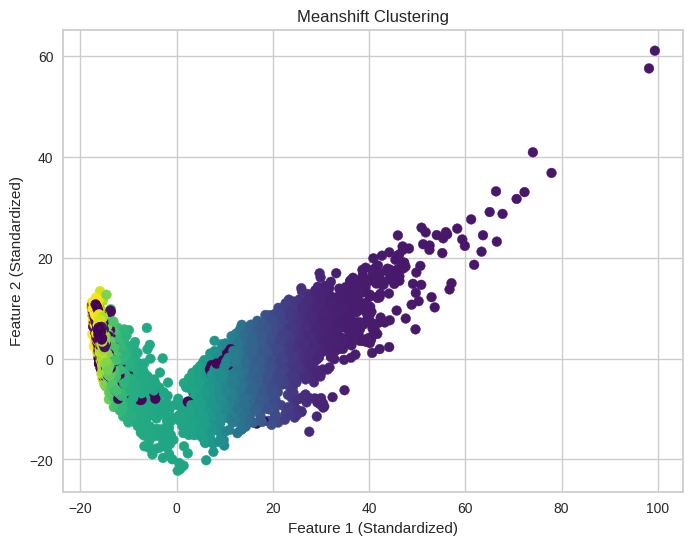

In [25]:
from sklearn.cluster import  estimate_bandwidth
n_band = estimate_bandwidth(X, quantile=0.2, n_samples=500)
mean_shift = MeanShift(bandwidth=n_band)
mean_shift_labels = mean_shift.fit_predict(X_pca)
print(n_band)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=mean_shift_labels, cmap='viridis')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.title('Meanshift Clustering')
plt.show()

### 3 Dimensional Visualization

interactive(children=(IntSlider(value=11, description='n_band', max=20, min=2), Output()), _dom_classes=('widg…

<function __main__.meanshift_clustering(n_band)>

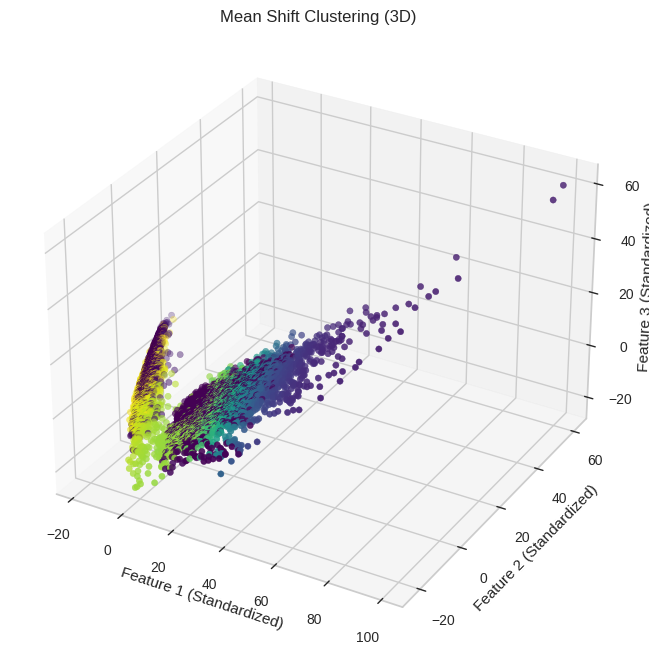

In [26]:
# Perform Mean Shift clustering with interactive widget
def meanshift_clustering(n_band):
    # Write the whole code for the function
    mean_shift = MeanShift(bandwidth=n_band)
    mean_shift_labels = mean_shift.fit_predict(X_pca)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1],X_pca[:, 1], c=mean_shift_labels, cmap='viridis')
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')
    ax.set_zlabel('Feature 3 (Standardized)')
    ax.set_title('Mean Shift Clustering (3D)')

interact(meanshift_clustering, n_band=(2,20,1))

***Congratulations! You have explored various clustering algorithms. Each algorithm has its own advantages and use cases. Remember, choosing the right algorithm and the right number of clusters is crucial. Feel free to experiment with different datasets and parameters to gain a better understanding.***

# **Bonus: To be done only if you have completed the above tasks.**

You can research and create a short blog on the topic of **Spectral Clustering Algortihm**. The best research will be edited and featured on the Synapse Instagram page. Happy coding! :)

### **Spectral Clustering Algortihm**

**Introduction**

Clustering Algorithms try to group data points with similar features together. Patterns come in various different shapes and sizes and human eyes can recognize all of them, geometrical shapes, half moons, spirals, but how can machines recognize them?

Various algorithms are used now a days to cluster data, conventional ones often try to make the clusters in a shape resembling a circle; K-means is one of the top players in the game. But that doesn't mean it doesn't has it's disadvantages. It follows the compactness approach and tries to shape the clusters into circles, which useful as it in many problems can cause anomelities in others. It relies only on the pairwise distances between points and fails to detect patterns. This is where spectral clustering comes into picture. It follows the connectivity approach in which distance is not the key factor and clusters come into many other shapes. In connectivity, the points in a cluster are either immediately next to each other (epsilon distance) or connected. Even if the distance is less, they are not put in the same cluster. In spectral clustering, we try to transform the data in a manner by which conventional algorithms can easily detect the right patterns. In
order to do that, we utilize eigenvalues and eigenvectors, thus explaining the
name spectral clustering.

**Steps**

The three major steps involved in spectral clustering are:
1. Constructing a similarity graph
2. Projecting data onto a lower-dimensional space
3. Clustering the data

**Advantages**

Spectral clustering helps us to overcome various problems in conventional clustering: shape of the cluster and cluster centroid. This is one of the many advantages.

1. It is a technique in data science to identify communities of nodes in a graph based on the edges connecting them.
2. This algorithm makes it easy to segregate data and form clusters.
3. It is flexible and allows to cluster non-graph datasets as well.
4. In K means, many iterations are required to determine the cluster centroid. In spectral, the clusters do not follow a fixed shape or pattern.
5. When compared with other algorithms, it is computationally fast for sparse datasets of several thousand data points.

**Disadvantages**

Though spectral clustering is a revolutionary algorithms, it still has some disadvantages. Some of them are:

1. Distance or Though it might be costly to compute for large datasets as eigenvalues and eigenvectors need to be computed and then clustering is to be done.
2. In comparison to other clustering techniques like k-means clustering, Spectral Clustering has the drawback of being rather slow. If your dataset has a large number of data points, a faster algorithm will be better.
3. Looking at the affinity of the matrix, some of the eigenvalues may be the same. This is called multiplicity. It can be hard to pick the number of clusters, and it might make it difficult to tell which group something belongs to.

**Applications**

There is an endless amount of application of clustering algorithms, few are mentioned below,

1. Image segmentation: While dealing with images,  considering the pixel data results in a huge dataset which is overcome by segmenting the images by applying the clustering algorithms only to small blocks of the image and
then merge the resulting segments with methods like a stochastic ensemble
consensus.

2. Signal Theory :E.g. speech separation. For instance, if voices of two poeople are taken and we want to seperate the linear mixture of signals and filter out the
individual voices, spectral clustering could be employed.

3. Gene Expression analysis and Bioinformatics: Spectral clustering in gene analysis is often used to cluster the gene expression data, providing insights in the biological relationships between the genes.

4. Text clustering and document classification: Spectral clustering creates a document similarity graph, reduces dimensionality, and applies k-means clustering for meaningful document grouping, enhancing text clustering and classification tasks with semantic insights.

**Conclusion**

One of the many clustering algorithms in unsupervised learning is Spectral Clustering. It makes use of eiganvalues and eiganvectors to determine the connected points and finds its application where complex clusters are required. It is a versatile and powerful technique with applications spanning various fields from image segmentation to gene expression. It's ability to detect complex relationships and hidden structures makes it an ideal choice for researchers and practitioners seeking meaningful insights from their datasets.

# **End of Task**

> ©DJS Synapse 2023 - 2024